## Homework - California Housing Prices

In this homework, we will create a linear regression model that predict the price of houses in California.

In [5]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


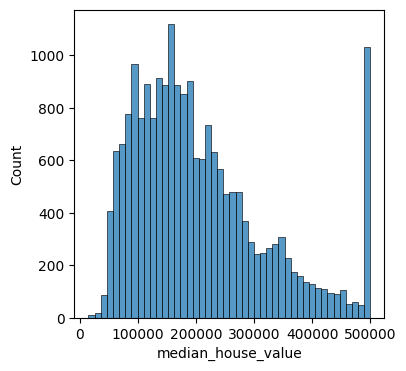

In [8]:
plt.figure(figsize=(4,4))
sns.histplot(df['median_house_value'], kde=False);

The distribution is skewed to the right, but does not have a long tail.

For this homework, we are going to use the following features:

In [9]:
features = ['latitude',
            'longitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'median_house_value']

df = df[features]

##### Question 1
Find a feature with missing values. How many missing values does it have?

In [10]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

Total bedrooms features have 207 missing values. 

##### Question 2
What's the median (50% percentile) for variable 'population'?

In [11]:
df['population'].median()

1166.0

Split the data
- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Make sure that the target value ('median_house_value') is not in your dataframe.
- Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [12]:
# Split

##### Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good


In [13]:
#

##### Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [14]:
#

##### Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))